# [7] Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## [7.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer



# using the SQLite Table to read data. Give proper path for data resources
con = sqlite3.connect('./amazon fine food/database.sqlite') 



#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con) 




# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [2]:
filtered_data.shape #looking at the number of attributes and size of the data
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


#  Exploratory Data Analysis

## [7.1.2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [3]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [4]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [5]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [6]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)
display


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [8]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]


In [9]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

## 7.2.3  Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [10]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;    

        

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [11]:

# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{"you're", 'for', 'not', 'between', 'out', 'ourselves', 'him', 'its', 'through', "that'll", 'didn', 'few', 'shouldn', 'now', 'shan', 'have', 'ours', 'was', 'after', 'is', 'me', 'ma', 'wasn', 'what', 'am', 'd', 'down', 'does', 'whom', "won't", 'that', 'hers', 'own', 'more', "haven't", 'from', 'will', 'other', "hasn't", 'she', 'do', 'while', "it's", "doesn't", "weren't", 'where', "you'd", 'yourselves', "should've", 'doing', 'but', 'of', 'll', "wouldn't", 'which', 'too', 'further', 'are', "needn't", "wasn't", 'a', 'm', 'yourself', 'below', 'no', "didn't", 'both', 're', 'o', 'doesn', 'on', 'before', 'them', 'so', 'we', 'up', 'any', 'because', 'here', 'same', 'ain', 'hadn', 'during', 'needn', "she's", 'again', 'this', 'by', "you'll", "isn't", 'these', 'her', 'had', 'than', 't', 'their', 'yours', 'very', 'then', 'weren', 'once', "mightn't", 'with', 'over', 'all', 'such', 'aren', 'only', 'it', 'myself', 'won', 've', 'our', 'those', 'as', 'i', 'some', "shan't", 'into', 'until', "don't", 'mustn

In [12]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [13]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 

In [14]:
final.head(3) #below the processed review can be seen in the CleanedText Column 


# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn, flavor=None, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

# Time based sorting of reviews

In [14]:
final_sorted_data=final.sort_values('Time')
y = np.array(final_sorted_data['Score'])

# [7.2.2] Bag of Words (BoW)

In [15]:
X_data = final_sorted_data['Text'].values

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.metrics import confusion_matrix

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [17]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X_data, y, test_size=0.3, random_state=0)


In [19]:
#BoW
count_unigram_vect = CountVectorizer() #in scikit-learn
final_counts = count_unigram_vect.fit_transform(X_train)


In [25]:
final_counts.get_shape()

(254919, 96249)

## [7.2.4] Bi-Grams and n-Grams.

**Motivation**

Now that we have our list of words describing positive and negative reviews lets analyse them.<br>

We begin analysis by getting the frequency distribution of the words as shown below

In [44]:
freq_dist_positive=nltk.FreqDist(all_positive_words)
freq_dist_negative=nltk.FreqDist(all_negative_words)
print("Most Common Positive Words : ",freq_dist_positive.most_common(20))
print("Most Common Negative Words : ",freq_dist_negative.most_common(20))

Most Common Positive Words :  [(b'like', 139429), (b'tast', 129047), (b'good', 112766), (b'flavor', 109624), (b'love', 107357), (b'use', 103888), (b'great', 103870), (b'one', 96726), (b'product', 91033), (b'tri', 86791), (b'tea', 83888), (b'coffe', 78814), (b'make', 75107), (b'get', 72125), (b'food', 64802), (b'would', 55568), (b'time', 55264), (b'buy', 54198), (b'realli', 52715), (b'eat', 52004)]
Most Common Negative Words :  [(b'tast', 34585), (b'like', 32330), (b'product', 28218), (b'one', 20569), (b'flavor', 19575), (b'would', 17972), (b'tri', 17753), (b'use', 15302), (b'good', 15041), (b'coffe', 14716), (b'get', 13786), (b'buy', 13752), (b'order', 12871), (b'food', 12754), (b'dont', 11877), (b'tea', 11665), (b'even', 11085), (b'box', 10844), (b'amazon', 10073), (b'make', 9840)]


<b>Observation:-</b> From the above it can be seen that the most common positive and the negative words overlap for eg. 'like' could be used as 'not like' etc. <br>
So, it is a good idea to consider pairs of consequent words (bi-grams) or q sequnce of n consecutive words (n-grams)

In [29]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
count_vect = CountVectorizer(ngram_range=(1,2) ) #in scikit-learn
final_bigram_counts = count_vect.fit_transform(X_train)


In [30]:
final_bigram_counts.get_shape()

(254919, 2328049)

In [29]:
a=np.arange(0.00001, 0.00005, 0.00001)
a

array([1.e-05, 2.e-05, 3.e-05, 4.e-05])

In [20]:
# Spliting of train and CV data
#X_1, X_test, y_1, y_test = cross_validation.train_test_split(final_counts, y, test_size=0.3, random_state=0)
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(final_counts, y_train, test_size=0.3)

# 10 fold Cross Validation for alpha range from 10^-3 to 10^-5
alphas = np.arange(0.00001, 0.00101, 0.00001)
#neighbors = list(filter(lambda x: x % 2 != 0, myList))

cv_scores = []

for alpha in alphas:
    nb = MultinomialNB(alpha=alpha, class_prior=None, fit_prior=True)
    scores = cross_val_score(nb, X_tr, y_tr, cv=10, scoring='accuracy')
    print('\nThe cross validation score for alpha = {} is {}.'.format(alpha,scores.mean()))
    cv_scores.append(scores.mean())

MSE = [1 - x for x in cv_scores]

optimal_alpha = alphas[MSE.index(min(MSE))]



The cross validation score for alpha = 1e-05 is 0.8944537259380112.

The cross validation score for alpha = 2e-05 is 0.8950981917932206.

The cross validation score for alpha = 3.0000000000000004e-05 is 0.8954624548704995.

The cross validation score for alpha = 4e-05 is 0.8956193722450954.

The cross validation score for alpha = 5e-05 is 0.895837930593955.

The cross validation score for alpha = 6e-05 is 0.896000450522858.

The cross validation score for alpha = 7.000000000000001e-05 is 0.8961573625584152.

The cross validation score for alpha = 8e-05 is 0.8962750469776649.

The cross validation score for alpha = 9e-05 is 0.8963759161963957.

The cross validation score for alpha = 0.0001 is 0.896443167890653.

The cross validation score for alpha = 0.00011 is 0.8964992094511957.

The cross validation score for alpha = 0.00012 is 0.8965552484992412.

The cross validation score for alpha = 0.00013000000000000002 is 0.8966393097409346.

The cross validation score for alpha = 0.000140000

In [21]:
print('\nThe optimal number of neighbors is %f.' % optimal_alpha)


The optimal number of neighbors is 0.001000.


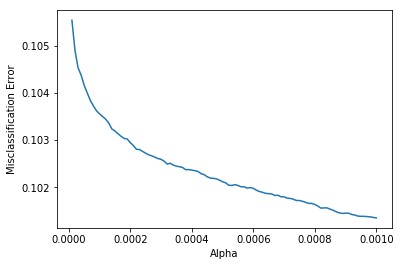

the misclassification error for each alpha value is :  [0.10555 0.1049  0.10454 0.10438 0.10416 0.104   0.10384 0.10372 0.10362
 0.10356 0.1035  0.10344 0.10336 0.10324 0.10319 0.10314 0.10308 0.10304
 0.10302 0.10295 0.10288 0.10281 0.1028  0.10276 0.10272 0.10269 0.10267
 0.10264 0.10261 0.10259 0.10255 0.10249 0.10251 0.10247 0.10245 0.10244
 0.10242 0.10237 0.10237 0.10236 0.10235 0.10234 0.10229 0.10227 0.10222
 0.1022  0.10219 0.10218 0.10215 0.10212 0.10209 0.10204 0.10204 0.10205
 0.10204 0.10201 0.10201 0.10198 0.10199 0.10198 0.10194 0.10191 0.10189
 0.10187 0.10186 0.10186 0.10183 0.10183 0.1018  0.1018  0.10177 0.10176
 0.10175 0.10172 0.10172 0.1017  0.10168 0.10166 0.10166 0.10163 0.1016
 0.10156 0.10156 0.10156 0.10153 0.10151 0.10148 0.10146 0.10144 0.10145
 0.10145 0.10142 0.10141 0.10139 0.10138 0.10138 0.10138 0.10137 0.10136
 0.10135]


In [22]:
# plot misclassification error vs k 
plt.plot(alphas, MSE)


plt.xlabel('Alpha')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each alpha value is : ", np.round(MSE,5))

In [23]:
#count_unigram_train_vect = CountVectorizer(vocabulary=count_unigram_vect.get_feature_names())
X_test_vector = count_unigram_vect.transform(X_test)

In [24]:
X_test_vector.get_shape()

(109252, 96249)

In [27]:
nb_optimal = MultinomialNB(alpha=optimal_alpha, class_prior=None, fit_prior=True)

nb_optimal.fit(X_tr, y_tr)
#X_test_vector = count_unigram_vect.fit_transform(X_test)
pred = nb_optimal.predict(X_test_vector)

acc = accuracy_score(y_test, pred) * 100

In [28]:
print('\nThe accuracy of the Multinomial Naive Bayes of unigram BOW for alpha = %f is %f%%' % (optimal_alpha, acc))


The accuracy of the Multinomial Naive Bayes of unigram BOW for alpha = 0.001000 is 90.105444%


In [31]:
confusion_matrix(y_test, pred)

array([[11987,  5226],
       [ 5584, 86455]], dtype=int64)

In [32]:
from sklearn.metrics import precision_recall_fscore_support as score
precision, recall, fscore, support = score(y_test, pred)



In [33]:
print('Value for alpha = ',optimal_alpha)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))

Value for alpha =  0.001
precision: [0.68220363 0.942998  ]
recall: [0.69639226 0.93933007]
fscore: [0.68922493 0.94116046]


In [72]:
#https://stackoverflow.com/questions/50526898/how-to-get-feature-importance-in-naive-bayes link for this code
neg_class_prob_sorted = nb_optimal.feature_log_prob_[0, :].argsort()
pos_class_prob_sorted = nb_optimal.feature_log_prob_[1, :].argsort()

print('Most important negative feature')
print(np.take(count_unigram_vect.get_feature_names(), neg_class_prob_sorted[:15]))
print('Most important positive feature')
print(np.take(count_unigram_vect.get_feature_names(), pos_class_prob_sorted[:15]))

Most important negative feature
['inexpedience' 'minituare' 'minitse' 'minites' 'minita' 'ministrone'
 'ministerial' 'minister' 'minischnauzers' 'miniture' 'minipoodles'
 'minipockets' 'miniority' 'minions' 'minion']
Most important positive feature
['inexpedience' 'intimated' 'intimately' 'intimdating' 'intimidator'
 'intinerary' 'intitally' 'intollerent' 'intolorances' 'intolorant'
 'intolorence' 'inton' 'intonation' 'intoned' 'intorduce']


# Bigram anaysis BOW

In [35]:
# Spliting of train and test data
#X_1, X_test, y_1, y_test = cross_validation.train_test_split(final_bigram_counts, y, test_size=0.3, random_state=0)
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(final_bigram_counts, y_train, test_size=0.3)

# 10 fold Cross Validation for alpha range from 10^-3 to 10^-5
alphas = np.arange(0.00001, 0.00101, 0.00001)
#neighbors = list(filter(lambda x: x % 2 != 0, myList))

cv_scores = []

for alpha in alphas:
    nb = MultinomialNB(alpha=alpha, class_prior=None, fit_prior=True)
    scores = cross_val_score(nb, X_tr, y_tr, cv=10, scoring='accuracy')
    print('\nThe cross validation score for alpha = {} is {}.'.format(alpha,scores.mean()))
    cv_scores.append(scores.mean())

MSE = [1 - x for x in cv_scores]

optimal_alpha = alphas[MSE.index(min(MSE))]


The cross validation score for alpha = 1e-05 is 0.8988696773600818.

The cross validation score for alpha = 2e-05 is 0.9012121637738817.

The cross validation score for alpha = 3.0000000000000004e-05 is 0.9027140412273156.

The cross validation score for alpha = 4e-05 is 0.9038572628690089.

The cross validation score for alpha = 5e-05 is 0.9046642480236944.

The cross validation score for alpha = 6e-05 is 0.9053367316749071.

The cross validation score for alpha = 7.000000000000001e-05 is 0.9059363632757964.

The cross validation score for alpha = 8e-05 is 0.9064127013085805.

The cross validation score for alpha = 9e-05 is 0.9068834367868808.

The cross validation score for alpha = 0.0001 is 0.9073093493170277.

The cross validation score for alpha = 0.00011 is 0.907690421313372.

The cross validation score for alpha = 0.00012 is 0.9080154574019751.

The cross validation score for alpha = 0.00013000000000000002 is 0.9083180732236065.

The cross validation score for alpha = 0.0001400

In [36]:
print('\nThe optimal number of neighbors is %f.' % optimal_alpha)


The optimal number of neighbors is 0.001000.


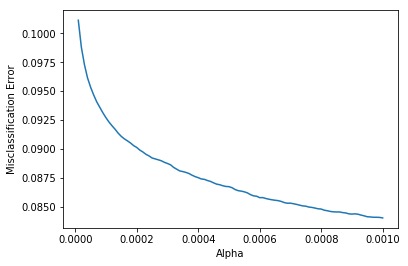

the misclassification error for each alpha value is :  [0.10113 0.09879 0.09729 0.09614 0.09534 0.09466 0.09406 0.09359 0.09312
 0.09269 0.09231 0.09198 0.09168 0.09135 0.09107 0.09086 0.09068 0.0905
 0.09028 0.09012 0.08989 0.08973 0.08952 0.08938 0.0892  0.08913 0.08905
 0.08896 0.08883 0.08873 0.08862 0.08839 0.08824 0.08808 0.08803 0.08796
 0.08786 0.08771 0.08759 0.0875  0.08739 0.08736 0.08725 0.08718 0.08705
 0.08694 0.08689 0.0868  0.08674 0.08672 0.08663 0.08648 0.08637 0.08634
 0.08627 0.08618 0.08603 0.08593 0.08589 0.08577 0.08578 0.0857  0.08564
 0.08558 0.08555 0.08551 0.08544 0.08534 0.08529 0.08529 0.08524 0.08519
 0.08512 0.08506 0.08503 0.08496 0.08492 0.08487 0.08481 0.08478 0.08468
 0.08464 0.08458 0.08454 0.08453 0.08453 0.08448 0.08445 0.08437 0.08435
 0.08437 0.08434 0.08426 0.08419 0.08412 0.0841  0.08407 0.08407 0.08406
 0.08402]


In [37]:
# plot misclassification error vs k 
plt.plot(alphas, MSE)


plt.xlabel('Alpha')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each alpha value is : ", np.round(MSE,5))

In [38]:
nb_optimal = MultinomialNB(alpha=optimal_alpha, class_prior=None, fit_prior=True)

nb_optimal.fit(X_tr, y_tr)
X_test_vector = count_vect.transform(X_test)
pred = nb_optimal.predict(X_test_vector)

acc = accuracy_score(y_test, pred) * 100

In [39]:
print('\nThe accuracy of the Multinomial Naive Bayes of unigram BOW for alpha = %f is %f%%' % (optimal_alpha, acc))


The accuracy of the Multinomial Naive Bayes of unigram BOW for alpha = 0.001000 is 91.175448%


In [40]:
confusion_matrix(y_test, pred)

array([[ 9514,  7699],
       [ 1942, 90097]], dtype=int64)

In [41]:

precision, recall, fscore, support = score(y_test, pred)
print('Value for alpha = ',optimal_alpha)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))

Value for alpha =  0.001
precision: [0.83048184 0.9212749 ]
recall: [0.55272178 0.97890025]
fscore: [0.66371342 0.94921379]


In [81]:
neg_class_prob_sorted = nb_optimal.feature_log_prob_[0, :].argsort()
pos_class_prob_sorted = nb_optimal.feature_log_prob_[1, :].argsort()

print('Most important negative feature')
print(np.take(count_vect.get_feature_names(), neg_class_prob_sorted[:15]))
print('Most important positive feature')
print(np.take(count_vect.get_feature_names(), pos_class_prob_sorted[:15]))

Most important negative feature
['linden eeekkk' 'oven batch' 'oven beautifully' 'oven beeps' 'oven being'
 'oven best' 'oven bit' 'oven black' 'oven both' 'oven brand' 'oven bread'
 'oven brew' 'oven brown' 'oven brushed' 'oven by']
Most important positive feature
['linden eeekkk' 'generation after' 'sam with' 'generation 1992'
 'generation 1984' 'generation 1962' 'sam would' 'generating pad'
 'sam you' 'sam who' 'generating lot' 'generating impulse'
 'generating further' 'generates so' 'generates relative']


# [7.2.5] TF-IDF

In [19]:

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(X_train)


In [20]:
# Spliting of train and test data
#X_1, X_test, y_1, y_test = cross_validation.train_test_split(final_tf_idf, y, test_size=0.3, random_state=0)
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(final_tf_idf, y_train, test_size=0.3)

# 10 fold Cross Validation for alpha range from 10^-3 to 10^-5
alphas = np.arange(0.00001, 0.00101, 0.00001)
#neighbors = list(filter(lambda x: x % 2 != 0, myList))

cv_scores = []

for alpha in alphas:
    nb = MultinomialNB(alpha=alpha, class_prior=None, fit_prior=True)
    scores = cross_val_score(nb, X_tr, y_tr, cv=10, scoring='accuracy')
    print('\nThe cross validation score for alpha = {} is {}.'.format(alpha,scores.mean()))
    cv_scores.append(scores.mean())

MSE = [1 - x for x in cv_scores]

optimal_alpha = alphas[MSE.index(min(MSE))]


The cross validation score for alpha = 1e-05 is 0.8926548425059979.

The cross validation score for alpha = 2e-05 is 0.8955185165964217.

The cross validation score for alpha = 3.0000000000000004e-05 is 0.8972333445060381.

The cross validation score for alpha = 4e-05 is 0.8986847882928386.

The cross validation score for alpha = 5e-05 is 0.8997159434591092.

The cross validation score for alpha = 6e-05 is 0.9004388626621027.

The cross validation score for alpha = 7.000000000000001e-05 is 0.9012962849394605.

The cross validation score for alpha = 8e-05 is 0.9020192079113751.

The cross validation score for alpha = 9e-05 is 0.9025515875045258.

The cross validation score for alpha = 0.0001 is 0.9031007866950655.

The cross validation score for alpha = 0.00011 is 0.9035379040207333.

The cross validation score for alpha = 0.00012 is 0.9038741449042942.

The cross validation score for alpha = 0.00013000000000000002 is 0.9042159921109783.

The cross validation score for alpha = 0.000140

In [21]:
print('\nThe optimal number of neighbors is %f.' % optimal_alpha)


The optimal number of neighbors is 0.000980.


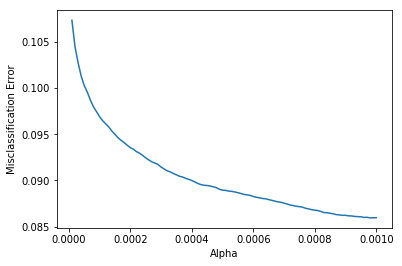

the misclassification error for each alpha value is :  [0.10735 0.10448 0.10277 0.10132 0.10028 0.09956 0.0987  0.09798 0.09745
 0.0969  0.09646 0.09613 0.09578 0.09535 0.09499 0.09463 0.09434 0.09409
 0.09381 0.09355 0.09339 0.09312 0.09295 0.09271 0.09245 0.09222 0.09201
 0.09188 0.09173 0.09145 0.09124 0.09104 0.09092 0.09075 0.09061 0.09045
 0.09037 0.09023 0.09012 0.08999 0.08983 0.08967 0.08955 0.08948 0.08945
 0.0894  0.08931 0.08922 0.08904 0.08895 0.08892 0.08885 0.08882 0.08875
 0.08867 0.08858 0.08848 0.08844 0.08838 0.08826 0.08817 0.08812 0.08804
 0.08802 0.08793 0.08785 0.08776 0.08768 0.08764 0.08754 0.08745 0.08734
 0.08728 0.0872  0.08716 0.08711 0.08699 0.08692 0.08683 0.08679 0.08674
 0.08664 0.08652 0.0865  0.08645 0.08639 0.0863  0.08627 0.08622 0.08622
 0.08617 0.08616 0.0861  0.08608 0.08607 0.086   0.08601 0.08594 0.08596
 0.08597]


In [22]:
plt.plot(alphas, MSE)


plt.xlabel('Alpha')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each alpha value is : ", np.round(MSE,5))

In [23]:
nb_optimal = MultinomialNB(alpha=optimal_alpha, class_prior=None, fit_prior=True)

nb_optimal.fit(X_tr, y_tr)
X_test_vector = tf_idf_vect.transform(X_test)
pred = nb_optimal.predict(X_test_vector)

acc = accuracy_score(y_test, pred) * 100

In [24]:
print('\nThe accuracy of the Multinomial Naive Bayes of unigram BOW for alpha = %f is %f%%' % (optimal_alpha, acc))


The accuracy of the Multinomial Naive Bayes of unigram BOW for alpha = 0.000980 is 90.211621%


In [25]:
confusion_matrix(y_test, pred)


array([[ 7534,  9679],
       [ 1015, 91024]], dtype=int64)

In [28]:
precision, recall, fscore, support = score(y_test, pred)
print('Value for alpha = ',optimal_alpha)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))

Value for alpha =  0.00098
precision: [0.88127266 0.90388568]
recall: [0.43769244 0.98897207]
fscore: [0.58489248 0.9445165 ]


In [29]:
neg_class_prob_sorted = nb_optimal.feature_log_prob_[0, :].argsort()
pos_class_prob_sorted = nb_optimal.feature_log_prob_[1, :].argsort()

print('Most important negative feature')
print(np.take(tf_idf_vect.get_feature_names(), neg_class_prob_sorted[:15]))
print('Most important positive feature')
print(np.take(tf_idf_vect.get_feature_names(), pos_class_prob_sorted[:15]))

Most important negative feature
['ît real' 'little snow' 'little snouts' 'little snot' 'little snoot'
 'little snooping' 'little snobby' 'stated extremely' 'little snickers'
 'little sneeze' 'little sneaky' 'little snub' 'little sneaks'
 'little snap' 'little snail']
Most important positive feature
['linking these' 'label well' 'twinigs' 'stirred ignored' 'label way'
 'twings to' 'twings' 'label warrants' 'twingle in' 'cracker unless'
 'stirred loving' 'label warning' 'twingle' 'label vitamin'
 'label violation']


Here in TF-IDF negative and positive features word 'little' is highly used in -ve review
and word 'label' is highly used in positive review

# Conclusion

All Model were tested on complete data with 30% test data and remaining as train data with 10 fold cross validation on time base splited data precision recall and f1 score data have -ve and +ve value respectively for all vectorisation

"TF-IDF" : Accuracy = 91.22% , Best alpha= 0.098 , 

Precision = [0.88127266 0.90388568], 

Recall = [0.43769244 0.98897207]

F1 Score = [0.58489248 0.9445165]


"Bigram BOW" : Accuracy = 91.18% , Best alpha= 0.001 ,

precision: [0.83048184 0.9212749]

recall: [0.55272178 0.97890025]

fscore: [0.66371342 0.94921379]


"Unigram BOW" : Accuracy = 90.12% , Best alpha= 0.001 

precision: [0.68220363 0.942998]

recall: [0.69639226 0.93933007]

fscore: [0.68922493 0.94116046]


Graph of alpha shows that the behaviour of system is 'parabolic' and alpha value improves system performance for low value but close to zero for higher value with large positive value alpha system performance decreasing as it is clear in graph 

TF-IDF has best accuracy followed by bigram BOW And Unigram BOW

Precision value is also improve in TF-IDF W2Vec